<a href="https://colab.research.google.com/github/Simalg/Simalg/blob/main/Covid19VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import load_img, img_to_array

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_path = "/content/drive/MyDrive/Data/train"

In [ ]:
test_path = "/content/drive/MyDrive/Data/test"

In [ ]:
data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = data_gen.flow_from_directory(
  train_path,
  target_size=(224, 224),
  batch_size=4,
  class_mode='categorical',
  shuffle=True)

Found 5144 images belonging to 3 classes.


In [ ]:
test_generator = data_gen.flow_from_directory(
  test_path,
  target_size=(224, 224),
  batch_size=16, #görüntüleri daha küçük şekilde parçalara böler
  class_mode='categorical',
  shuffle=False)

Found 1288 images belonging to 3 classes.


In [ ]:
input_shape, num_classes = (224, 224, 3), 3

In [ ]:
input = Input(shape=input_shape)

base_model = VGG19(include_top=False, pooling="avg", weights="imagenet")(input)
dense_layer = Dense(64, activation='relu')(base_model)
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

model = Model(inputs=input, outputs=output_layer)
model.layers[0].trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 20057411 (76.51 MB)
Trainable params: 20057411 (76.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
fit_history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=test_generator,
)

<ipython-input-14-2e5dbd1feb0c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


Epoch 1/20
1286/1286 [==============================] - 1694s 1s/step - loss: 0.4146 - accuracy: 0.8320 - precision: 0.8435 - recall: 0.8184 - val_loss: 0.1568 - val_accuracy: 0.9550 - val_precision: 0.9562 - val_recall: 0.9488
Epoch 2/20
1286/1286 [==============================] - 155s 121ms/step - loss: 0.1677 - accuracy: 0.9360 - precision: 0.9379 - recall: 0.9339 - val_loss: 0.1638 - val_accuracy: 0.9371 - val_precision: 0.9399 - val_recall: 0.9348
Epoch 3/20
1286/1286 [==============================] - 155s 120ms/step - loss: 0.1166 - accuracy: 0.9594 - precision: 0.9599 - recall: 0.9586 - val_loss: 0.1423 - val_accuracy: 0.9573 - val_precision: 0.9573 - val_recall: 0.9573
Epoch 4/20
1286/1286 [==============================] - 155s 120ms/step - loss: 0.1361 - accuracy: 0.9528 - precision: 0.9545 - recall: 0.9510 - val_loss: 0.0880 - val_accuracy: 0.9689 - val_precision: 0.9689 - val_recall: 0.9682
Epoch 5/20
1286/1286 [==============================] - 155s 120ms/step - loss: 0.

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


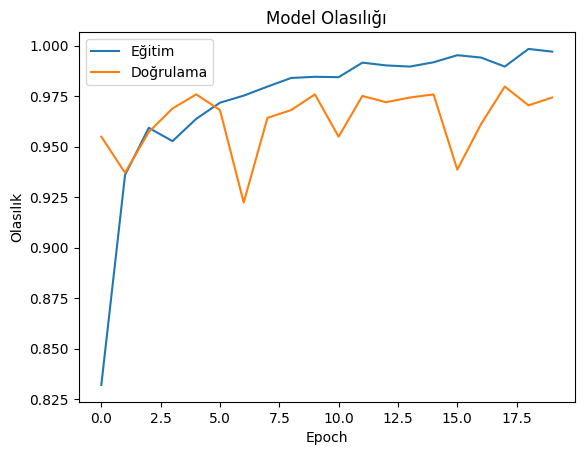

In [ ]:
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('Model Olasılığı')
plt.ylabel('Olasılık')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper left')
plt.show()

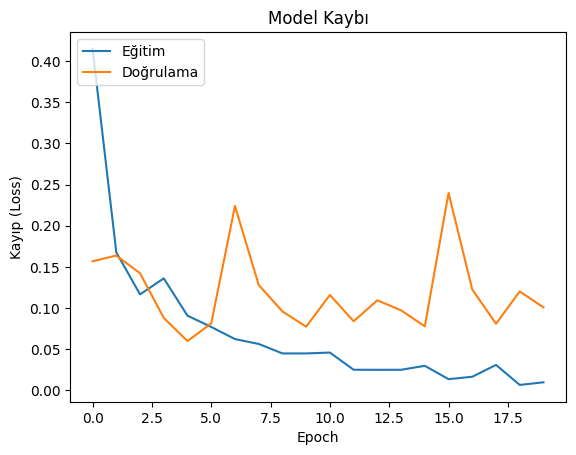

In [ ]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model Kaybı')
plt.ylabel('Kayıp (Loss)')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_generator)

81/81 [==============================] - 20s 228ms/step - loss: 0.1009 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744


In [ ]:
F1_Skoru = ((precision * recall) / (precision + recall)) * 2
F1_Skoru

0.9743788838386536

In [ ]:
y_true = test_generator.classes
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

cm = confusion_matrix(y_true, pred)

81/81 [==============================] - 19s 231ms/step


In [ ]:
report = classification_report(y_true, pred)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       116
           1       0.93      0.97      0.95       317
           2       0.99      0.97      0.98       855

    accuracy                           0.97      1288
   macro avg       0.97      0.98      0.97      1288
weighted avg       0.98      0.97      0.97      1288



In [ ]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[115   0   1]
 [  1 309   7]
 [  0  24 831]]
